# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 3.1MB/s eta 0:00:01
scikit-image 0.14.2 has requirement dask[array]>=1.0.0, but you'll have dask 0.16.1 which is incompatible.
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

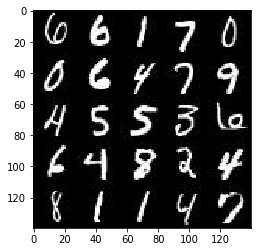

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

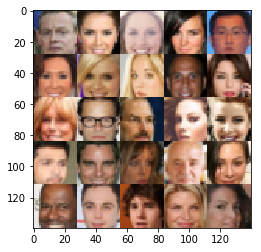

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    real_dim = (image_width, image_height, image_channels)
    
    input_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learn_rate = tf.placeholder(tf.float32, (), name='learn_rate')
   
    return (input_real, input_z, learn_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2  # for leaky relu
    # input layre is images 28x28x1( MNIST) or 28x28x3(CelebA)
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha*x1, x1)
        # 14x14x64
    
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha*bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha*bn3, bn3)
        # 4x4x256
        
        # flatten it 
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function

    if is_train:
        reuse = False
    else: 
        reuse = True
    with tf.variable_scope('generator', reuse=reuse):
    
        # first fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # reshape to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.0, x1) # relu
        # 4x4x512 
    
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.0, x2)
        # 7x7x256 
    
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(0.0, x3)
        # 14x14x128 now
    
        # output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28*28*out_channel_dim
        #print(logits.shape)
        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
   
    # label smooth
    smooth = 0.1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # get weights and bias
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [11]:
from workspace_utils import active_session
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, 
          get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    ### Build Model ### 
    print('Start training...')

    out_channel_dim = data_shape[-1]
    
    input_real , input_z, learn_rate = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt,  g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    ### Train Model ### 
    saver = tf.train.Saver()
    losses = []
    steps = 0

    with active_session():
        ### Run Session to train ### 
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for epoch_i in range(epoch_count):
                for batch_images in get_batches(batch_size):
                    # TODO: Train Model
            
                    batch_images = batch_images *2 # rescale [-0.5,0.5] ->[-1,1] 
                    # random noise input for generator
                    if steps == 0:
                        print(batch_images[0])
                        print('batch_images.shape', batch_images.shape)
                        print('data_shape', data_shape)
  
                    batch_z =  np.random.uniform(-1, 1, size=(batch_size, z_dim))
                                             
                    # run optimizer
                    _= sess.run(d_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, learn_rate:learning_rate})
                    _= sess.run(g_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, learn_rate:learning_rate})
                            
                    if steps % print_every == 0:
                        train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                        train_loss_g = g_loss.eval({input_z: batch_z})    
                    
                        print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Steps {}  ".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                        # Save losses to view after training
                        losses.append((train_loss_d, train_loss_g))                          
                
                    if steps % show_every == 0:
                        show_generator_output(sess, n_images, input_z, out_channel_dim, data_image_mode)
                    steps += 1
            
                print('Save checkpoint') # at the end of each epoch
                saver.save(sess, './my_dcgan.ckpt')
                                             
    print('End Training')
    return None
                       

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Start training...
batch_images.shape (100, 28, 28, 1)
data_shape (60000, 28, 28, 1)
Epoch 1/2... Steps 0   Discriminator Loss: 14.7801... Generator Loss: 0.0000


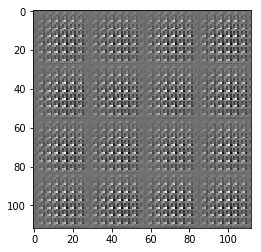

Epoch 1/2... Steps 10   Discriminator Loss: 0.5415... Generator Loss: 12.4941
Epoch 1/2... Steps 20   Discriminator Loss: 2.9862... Generator Loss: 10.7825
Epoch 1/2... Steps 30   Discriminator Loss: 0.4739... Generator Loss: 4.0408
Epoch 1/2... Steps 40   Discriminator Loss: 1.7682... Generator Loss: 9.5971
Epoch 1/2... Steps 50   Discriminator Loss: 0.5454... Generator Loss: 1.8940
Epoch 1/2... Steps 60   Discriminator Loss: 1.8157... Generator Loss: 0.3535
Epoch 1/2... Steps 70   Discriminator Loss: 0.7951... Generator Loss: 13.1172
Epoch 1/2... Steps 80   Discriminator Loss: 0.4752... Generator Loss: 2.8866
Epoch 1/2... Steps 90   Discriminator Loss: 0.7064... Generator Loss: 3.1805
Epoch 1/2... Steps 100   Discriminator Loss: 2.2770... Generator Loss: 0.2490


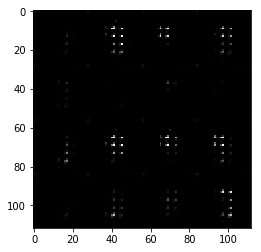

Epoch 1/2... Steps 110   Discriminator Loss: 0.3769... Generator Loss: 7.0841
Epoch 1/2... Steps 120   Discriminator Loss: 0.3506... Generator Loss: 5.7497
Epoch 1/2... Steps 130   Discriminator Loss: 0.3545... Generator Loss: 4.9001
Epoch 1/2... Steps 140   Discriminator Loss: 0.3442... Generator Loss: 5.9058
Epoch 1/2... Steps 150   Discriminator Loss: 0.4001... Generator Loss: 4.3128
Epoch 1/2... Steps 160   Discriminator Loss: 1.2406... Generator Loss: 1.2763
Epoch 1/2... Steps 170   Discriminator Loss: 0.4597... Generator Loss: 4.7848
Epoch 1/2... Steps 180   Discriminator Loss: 0.5087... Generator Loss: 4.0180
Epoch 1/2... Steps 190   Discriminator Loss: 0.5678... Generator Loss: 2.8557
Epoch 1/2... Steps 200   Discriminator Loss: 0.7169... Generator Loss: 1.4929


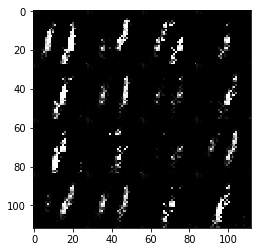

Epoch 1/2... Steps 210   Discriminator Loss: 1.1007... Generator Loss: 1.0601
Epoch 1/2... Steps 220   Discriminator Loss: 1.0572... Generator Loss: 1.3182
Epoch 1/2... Steps 230   Discriminator Loss: 1.6755... Generator Loss: 5.2382
Epoch 1/2... Steps 240   Discriminator Loss: 2.1925... Generator Loss: 6.5990
Epoch 1/2... Steps 250   Discriminator Loss: 0.5305... Generator Loss: 2.4855
Epoch 1/2... Steps 260   Discriminator Loss: 1.0912... Generator Loss: 1.0844
Epoch 1/2... Steps 270   Discriminator Loss: 0.8427... Generator Loss: 1.4728
Epoch 1/2... Steps 290   Discriminator Loss: 0.7764... Generator Loss: 1.8277
Epoch 1/2... Steps 300   Discriminator Loss: 1.5425... Generator Loss: 0.4712


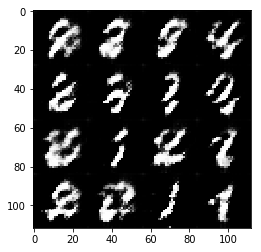

Epoch 1/2... Steps 310   Discriminator Loss: 1.5104... Generator Loss: 0.5369
Epoch 1/2... Steps 320   Discriminator Loss: 0.9975... Generator Loss: 1.0861
Epoch 1/2... Steps 330   Discriminator Loss: 1.1403... Generator Loss: 1.3880
Epoch 1/2... Steps 340   Discriminator Loss: 0.8686... Generator Loss: 1.8985
Epoch 1/2... Steps 350   Discriminator Loss: 1.1357... Generator Loss: 0.9546
Epoch 1/2... Steps 360   Discriminator Loss: 1.0119... Generator Loss: 1.6093
Epoch 1/2... Steps 370   Discriminator Loss: 1.3484... Generator Loss: 0.6461
Epoch 1/2... Steps 380   Discriminator Loss: 1.1890... Generator Loss: 0.9265
Epoch 1/2... Steps 390   Discriminator Loss: 1.0009... Generator Loss: 1.4765
Epoch 1/2... Steps 400   Discriminator Loss: 1.1884... Generator Loss: 1.3462


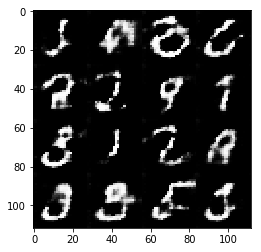

Epoch 1/2... Steps 410   Discriminator Loss: 1.2402... Generator Loss: 1.1209
Epoch 1/2... Steps 420   Discriminator Loss: 2.2269... Generator Loss: 0.2454
Epoch 1/2... Steps 430   Discriminator Loss: 1.0617... Generator Loss: 1.4770
Epoch 1/2... Steps 440   Discriminator Loss: 1.3350... Generator Loss: 2.1452
Epoch 1/2... Steps 450   Discriminator Loss: 1.3455... Generator Loss: 0.6066
Epoch 1/2... Steps 460   Discriminator Loss: 1.1104... Generator Loss: 1.3206
Epoch 1/2... Steps 470   Discriminator Loss: 1.1158... Generator Loss: 0.8941
Epoch 1/2... Steps 480   Discriminator Loss: 1.3503... Generator Loss: 0.6480
Epoch 1/2... Steps 490   Discriminator Loss: 1.1634... Generator Loss: 0.8585
Epoch 1/2... Steps 510   Discriminator Loss: 1.1679... Generator Loss: 0.9313
Epoch 1/2... Steps 520   Discriminator Loss: 1.2985... Generator Loss: 1.5773
Epoch 1/2... Steps 530   Discriminator Loss: 1.3460... Generator Loss: 0.7467
Epoch 1/2... Steps 540   Discriminator Loss: 1.4068... Generator

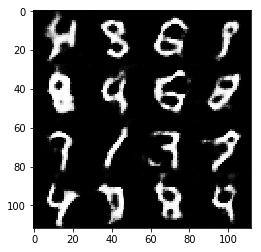

Epoch 2/2... Steps 610   Discriminator Loss: 1.1207... Generator Loss: 0.9608
Epoch 2/2... Steps 620   Discriminator Loss: 1.2459... Generator Loss: 1.5865
Epoch 2/2... Steps 630   Discriminator Loss: 1.2315... Generator Loss: 0.7253
Epoch 2/2... Steps 640   Discriminator Loss: 1.3698... Generator Loss: 0.5889
Epoch 2/2... Steps 650   Discriminator Loss: 1.1501... Generator Loss: 0.8768
Epoch 2/2... Steps 660   Discriminator Loss: 1.1162... Generator Loss: 0.9086
Epoch 2/2... Steps 670   Discriminator Loss: 1.4005... Generator Loss: 0.5327
Epoch 2/2... Steps 680   Discriminator Loss: 1.1325... Generator Loss: 1.0464
Epoch 2/2... Steps 690   Discriminator Loss: 1.1257... Generator Loss: 1.1290
Epoch 2/2... Steps 700   Discriminator Loss: 1.2170... Generator Loss: 0.9012


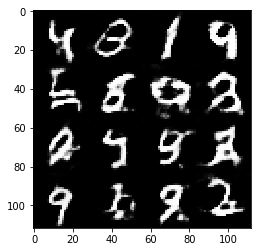

Epoch 2/2... Steps 710   Discriminator Loss: 1.1710... Generator Loss: 1.2590
Epoch 2/2... Steps 720   Discriminator Loss: 1.5811... Generator Loss: 0.4314
Epoch 2/2... Steps 730   Discriminator Loss: 1.1601... Generator Loss: 0.8889
Epoch 2/2... Steps 740   Discriminator Loss: 1.2183... Generator Loss: 0.8477
Epoch 2/2... Steps 750   Discriminator Loss: 1.3731... Generator Loss: 0.6326
Epoch 2/2... Steps 760   Discriminator Loss: 1.5059... Generator Loss: 0.4882
Epoch 2/2... Steps 770   Discriminator Loss: 1.1436... Generator Loss: 0.9050
Epoch 2/2... Steps 780   Discriminator Loss: 1.1899... Generator Loss: 0.9620
Epoch 2/2... Steps 790   Discriminator Loss: 1.3308... Generator Loss: 1.4075
Epoch 2/2... Steps 800   Discriminator Loss: 1.1864... Generator Loss: 1.0650


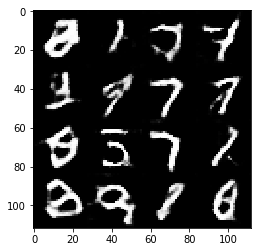

Epoch 2/2... Steps 810   Discriminator Loss: 1.1895... Generator Loss: 1.2192
Epoch 2/2... Steps 820   Discriminator Loss: 1.1398... Generator Loss: 1.1737
Epoch 2/2... Steps 830   Discriminator Loss: 1.3296... Generator Loss: 0.5461
Epoch 2/2... Steps 840   Discriminator Loss: 1.2938... Generator Loss: 0.7775
Epoch 2/2... Steps 850   Discriminator Loss: 1.2102... Generator Loss: 1.2219
Epoch 2/2... Steps 860   Discriminator Loss: 1.1649... Generator Loss: 0.7622
Epoch 2/2... Steps 880   Discriminator Loss: 1.1417... Generator Loss: 1.2455
Epoch 2/2... Steps 890   Discriminator Loss: 1.3181... Generator Loss: 1.2949
Epoch 2/2... Steps 900   Discriminator Loss: 1.5971... Generator Loss: 1.7496


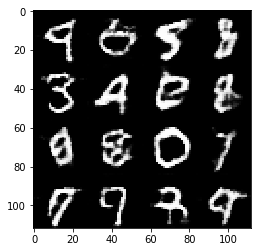

Epoch 2/2... Steps 910   Discriminator Loss: 1.0585... Generator Loss: 1.0943
Epoch 2/2... Steps 920   Discriminator Loss: 1.2331... Generator Loss: 1.3636
Epoch 2/2... Steps 930   Discriminator Loss: 1.3117... Generator Loss: 0.5768
Epoch 2/2... Steps 940   Discriminator Loss: 1.4526... Generator Loss: 0.4859
Epoch 2/2... Steps 950   Discriminator Loss: 1.3033... Generator Loss: 1.2626
Epoch 2/2... Steps 960   Discriminator Loss: 1.2092... Generator Loss: 0.8696
Epoch 2/2... Steps 970   Discriminator Loss: 1.2884... Generator Loss: 0.7335
Epoch 2/2... Steps 980   Discriminator Loss: 1.2052... Generator Loss: 0.8821
Epoch 2/2... Steps 990   Discriminator Loss: 1.1635... Generator Loss: 0.8212
Epoch 2/2... Steps 1000   Discriminator Loss: 1.3104... Generator Loss: 1.0622


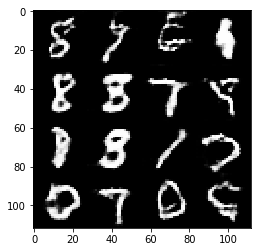

Epoch 2/2... Steps 1010   Discriminator Loss: 1.2086... Generator Loss: 1.2024
Epoch 2/2... Steps 1020   Discriminator Loss: 1.1765... Generator Loss: 0.7787
Epoch 2/2... Steps 1030   Discriminator Loss: 1.4126... Generator Loss: 0.5336
Epoch 2/2... Steps 1040   Discriminator Loss: 1.2493... Generator Loss: 0.7254
Epoch 2/2... Steps 1060   Discriminator Loss: 1.3178... Generator Loss: 0.8562
Epoch 2/2... Steps 1070   Discriminator Loss: 1.1853... Generator Loss: 0.8261
Epoch 2/2... Steps 1080   Discriminator Loss: 1.1888... Generator Loss: 1.0423
Epoch 2/2... Steps 1090   Discriminator Loss: 1.2337... Generator Loss: 0.6876
Epoch 2/2... Steps 1100   Discriminator Loss: 1.2926... Generator Loss: 0.6102


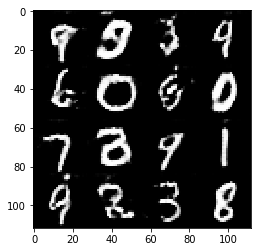

Epoch 2/2... Steps 1110   Discriminator Loss: 1.2802... Generator Loss: 0.6341
Epoch 2/2... Steps 1120   Discriminator Loss: 1.6011... Generator Loss: 0.4225
Epoch 2/2... Steps 1130   Discriminator Loss: 1.4890... Generator Loss: 0.4685
Epoch 2/2... Steps 1140   Discriminator Loss: 1.1538... Generator Loss: 1.5165
Epoch 2/2... Steps 1150   Discriminator Loss: 1.0736... Generator Loss: 2.3402
Epoch 2/2... Steps 1160   Discriminator Loss: 1.0925... Generator Loss: 0.8016
Epoch 2/2... Steps 1170   Discriminator Loss: 1.3034... Generator Loss: 0.8981
Epoch 2/2... Steps 1180   Discriminator Loss: 1.3582... Generator Loss: 0.5200
Epoch 2/2... Steps 1190   Discriminator Loss: 1.1774... Generator Loss: 1.2652
Save checkpoint
End Training


In [21]:
batch_size = 100
z_dim = 100
learning_rate = 0.002
beta1 = 0.5

print_every = 10
show_every  = 100
n_images = 16

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Start training...
batch_images.shape (128, 28, 28, 3)
data_shape (202599, 28, 28, 3)
Epoch 1/1... Steps 0   Discriminator Loss: 5.9836... Generator Loss: 0.0058


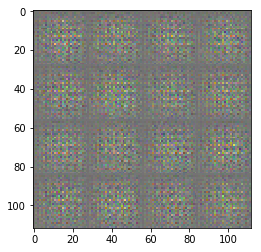

Epoch 1/1... Steps 10   Discriminator Loss: 0.9885... Generator Loss: 1.6393
Epoch 1/1... Steps 20   Discriminator Loss: 0.5814... Generator Loss: 3.1936
Epoch 1/1... Steps 30   Discriminator Loss: 0.6462... Generator Loss: 2.0786
Epoch 1/1... Steps 40   Discriminator Loss: 1.0205... Generator Loss: 0.8439
Epoch 1/1... Steps 50   Discriminator Loss: 1.0815... Generator Loss: 9.4151
Epoch 1/1... Steps 60   Discriminator Loss: 1.9873... Generator Loss: 0.2437
Epoch 1/1... Steps 70   Discriminator Loss: 0.8327... Generator Loss: 3.3825
Epoch 1/1... Steps 80   Discriminator Loss: 1.0496... Generator Loss: 4.5719
Epoch 1/1... Steps 90   Discriminator Loss: 0.6892... Generator Loss: 2.9430
Epoch 1/1... Steps 100   Discriminator Loss: 0.5745... Generator Loss: 2.1852


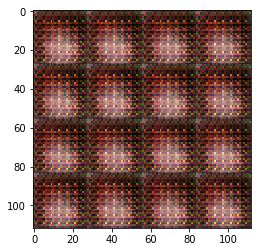

Epoch 1/1... Steps 110   Discriminator Loss: 0.6812... Generator Loss: 2.0896
Epoch 1/1... Steps 120   Discriminator Loss: 0.5056... Generator Loss: 2.7246
Epoch 1/1... Steps 130   Discriminator Loss: 0.5710... Generator Loss: 2.2186
Epoch 1/1... Steps 140   Discriminator Loss: 0.5031... Generator Loss: 3.1572
Epoch 1/1... Steps 150   Discriminator Loss: 0.6176... Generator Loss: 2.4847
Epoch 1/1... Steps 160   Discriminator Loss: 0.5057... Generator Loss: 2.4428
Epoch 1/1... Steps 170   Discriminator Loss: 0.4939... Generator Loss: 2.9015
Epoch 1/1... Steps 180   Discriminator Loss: 0.4423... Generator Loss: 3.0466
Epoch 1/1... Steps 190   Discriminator Loss: 0.4546... Generator Loss: 3.2831
Epoch 1/1... Steps 200   Discriminator Loss: 0.4732... Generator Loss: 3.1953


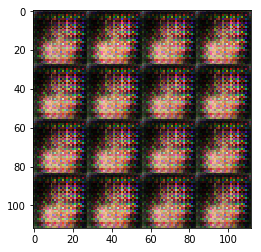

Epoch 1/1... Steps 210   Discriminator Loss: 0.4667... Generator Loss: 2.8807
Epoch 1/1... Steps 220   Discriminator Loss: 0.4801... Generator Loss: 2.8278
Epoch 1/1... Steps 230   Discriminator Loss: 0.4238... Generator Loss: 3.3738
Epoch 1/1... Steps 240   Discriminator Loss: 0.4162... Generator Loss: 3.1270
Epoch 1/1... Steps 250   Discriminator Loss: 0.3948... Generator Loss: 3.3301
Epoch 1/1... Steps 260   Discriminator Loss: 0.4214... Generator Loss: 3.2003
Epoch 1/1... Steps 270   Discriminator Loss: 0.4005... Generator Loss: 3.3738
Epoch 1/1... Steps 280   Discriminator Loss: 0.3955... Generator Loss: 3.4000
Epoch 1/1... Steps 290   Discriminator Loss: 0.3813... Generator Loss: 3.5247
Epoch 1/1... Steps 300   Discriminator Loss: 0.3806... Generator Loss: 3.5171


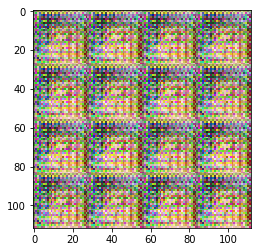

Epoch 1/1... Steps 310   Discriminator Loss: 0.3973... Generator Loss: 3.3339
Epoch 1/1... Steps 320   Discriminator Loss: 0.4222... Generator Loss: 3.2134
Epoch 1/1... Steps 330   Discriminator Loss: 0.4023... Generator Loss: 3.4594
Epoch 1/1... Steps 340   Discriminator Loss: 0.6931... Generator Loss: 1.4646
Epoch 1/1... Steps 350   Discriminator Loss: 0.9211... Generator Loss: 1.4432
Epoch 1/1... Steps 360   Discriminator Loss: 0.8020... Generator Loss: 1.5633
Epoch 1/1... Steps 370   Discriminator Loss: 0.7151... Generator Loss: 2.1602
Epoch 1/1... Steps 380   Discriminator Loss: 0.7080... Generator Loss: 1.5604
Epoch 1/1... Steps 390   Discriminator Loss: 0.8559... Generator Loss: 1.0253
Epoch 1/1... Steps 400   Discriminator Loss: 0.5776... Generator Loss: 2.4137


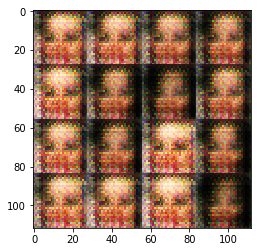

Epoch 1/1... Steps 410   Discriminator Loss: 0.4928... Generator Loss: 2.7839
Epoch 1/1... Steps 420   Discriminator Loss: 0.4711... Generator Loss: 3.7343
Epoch 1/1... Steps 430   Discriminator Loss: 0.5799... Generator Loss: 2.0816
Epoch 1/1... Steps 440   Discriminator Loss: 0.6218... Generator Loss: 2.1857
Epoch 1/1... Steps 450   Discriminator Loss: 1.2727... Generator Loss: 5.0164
Epoch 1/1... Steps 460   Discriminator Loss: 0.5911... Generator Loss: 2.7405
Epoch 1/1... Steps 470   Discriminator Loss: 0.7002... Generator Loss: 1.9965
Epoch 1/1... Steps 480   Discriminator Loss: 0.6329... Generator Loss: 1.8524
Epoch 1/1... Steps 490   Discriminator Loss: 0.6051... Generator Loss: 1.9840
Epoch 1/1... Steps 500   Discriminator Loss: 0.7865... Generator Loss: 1.7553


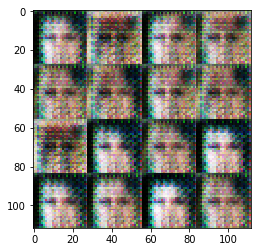

Epoch 1/1... Steps 510   Discriminator Loss: 0.7109... Generator Loss: 2.0504
Epoch 1/1... Steps 520   Discriminator Loss: 0.6384... Generator Loss: 2.0793
Epoch 1/1... Steps 530   Discriminator Loss: 0.8288... Generator Loss: 1.4696
Epoch 1/1... Steps 540   Discriminator Loss: 0.7960... Generator Loss: 3.5665
Epoch 1/1... Steps 550   Discriminator Loss: 0.6320... Generator Loss: 2.2380
Epoch 1/1... Steps 560   Discriminator Loss: 0.6321... Generator Loss: 2.1436
Epoch 1/1... Steps 570   Discriminator Loss: 0.5915... Generator Loss: 2.2780
Epoch 1/1... Steps 580   Discriminator Loss: 0.7468... Generator Loss: 2.3993
Epoch 1/1... Steps 590   Discriminator Loss: 0.5802... Generator Loss: 2.1874
Epoch 1/1... Steps 600   Discriminator Loss: 1.2402... Generator Loss: 3.2111


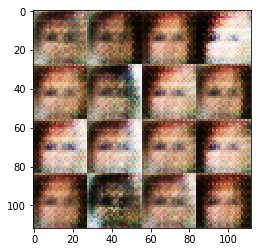

Epoch 1/1... Steps 610   Discriminator Loss: 0.8332... Generator Loss: 1.3625
Epoch 1/1... Steps 620   Discriminator Loss: 0.8246... Generator Loss: 1.5219
Epoch 1/1... Steps 630   Discriminator Loss: 1.7561... Generator Loss: 3.8400
Epoch 1/1... Steps 640   Discriminator Loss: 0.8891... Generator Loss: 1.4309
Epoch 1/1... Steps 650   Discriminator Loss: 0.7668... Generator Loss: 1.7577
Epoch 1/1... Steps 660   Discriminator Loss: 1.1248... Generator Loss: 0.9409
Epoch 1/1... Steps 670   Discriminator Loss: 1.8771... Generator Loss: 4.6620
Epoch 1/1... Steps 680   Discriminator Loss: 0.7130... Generator Loss: 2.3685
Epoch 1/1... Steps 690   Discriminator Loss: 0.9010... Generator Loss: 1.1537
Epoch 1/1... Steps 700   Discriminator Loss: 0.7535... Generator Loss: 1.6014


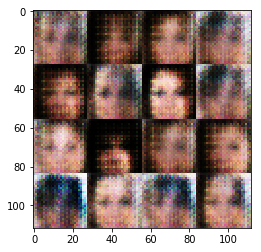

Epoch 1/1... Steps 710   Discriminator Loss: 1.0873... Generator Loss: 0.9436
Epoch 1/1... Steps 720   Discriminator Loss: 0.7829... Generator Loss: 1.6777
Epoch 1/1... Steps 730   Discriminator Loss: 0.9246... Generator Loss: 1.2720
Epoch 1/1... Steps 740   Discriminator Loss: 0.9640... Generator Loss: 2.1537
Epoch 1/1... Steps 750   Discriminator Loss: 1.2955... Generator Loss: 0.7206
Epoch 1/1... Steps 760   Discriminator Loss: 1.0899... Generator Loss: 2.6551
Epoch 1/1... Steps 770   Discriminator Loss: 0.8445... Generator Loss: 2.4252
Epoch 1/1... Steps 780   Discriminator Loss: 1.5139... Generator Loss: 0.5574
Epoch 1/1... Steps 790   Discriminator Loss: 0.7720... Generator Loss: 1.8194
Epoch 1/1... Steps 800   Discriminator Loss: 1.0211... Generator Loss: 1.2420


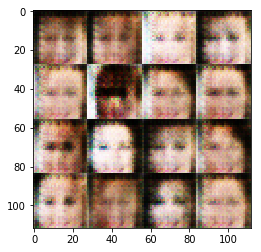

Epoch 1/1... Steps 810   Discriminator Loss: 0.9638... Generator Loss: 0.9665
Epoch 1/1... Steps 820   Discriminator Loss: 1.0217... Generator Loss: 3.0557
Epoch 1/1... Steps 830   Discriminator Loss: 0.8912... Generator Loss: 1.0796
Epoch 1/1... Steps 840   Discriminator Loss: 1.0500... Generator Loss: 1.9693
Epoch 1/1... Steps 850   Discriminator Loss: 0.9538... Generator Loss: 3.0670
Epoch 1/1... Steps 860   Discriminator Loss: 0.9785... Generator Loss: 1.8244
Epoch 1/1... Steps 870   Discriminator Loss: 0.9213... Generator Loss: 1.3929
Epoch 1/1... Steps 880   Discriminator Loss: 0.8440... Generator Loss: 2.7393
Epoch 1/1... Steps 890   Discriminator Loss: 0.9173... Generator Loss: 2.1470
Epoch 1/1... Steps 900   Discriminator Loss: 1.2603... Generator Loss: 1.8074


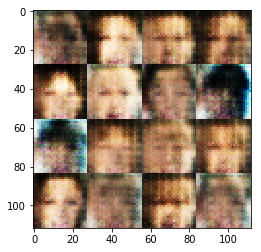

Epoch 1/1... Steps 910   Discriminator Loss: 0.9749... Generator Loss: 1.7424
Epoch 1/1... Steps 920   Discriminator Loss: 0.9609... Generator Loss: 1.4568
Epoch 1/1... Steps 930   Discriminator Loss: 1.1845... Generator Loss: 1.4495
Epoch 1/1... Steps 940   Discriminator Loss: 1.0376... Generator Loss: 1.0662
Epoch 1/1... Steps 950   Discriminator Loss: 1.0137... Generator Loss: 1.4573
Epoch 1/1... Steps 960   Discriminator Loss: 0.9471... Generator Loss: 1.6769
Epoch 1/1... Steps 970   Discriminator Loss: 1.0550... Generator Loss: 1.5970
Epoch 1/1... Steps 980   Discriminator Loss: 0.9778... Generator Loss: 1.7562
Epoch 1/1... Steps 990   Discriminator Loss: 0.9551... Generator Loss: 1.4766
Epoch 1/1... Steps 1000   Discriminator Loss: 0.9139... Generator Loss: 1.3857


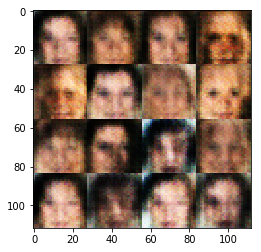

Epoch 1/1... Steps 1010   Discriminator Loss: 0.9703... Generator Loss: 1.1564
Epoch 1/1... Steps 1020   Discriminator Loss: 1.2035... Generator Loss: 0.7574
Epoch 1/1... Steps 1030   Discriminator Loss: 0.8370... Generator Loss: 1.6317
Epoch 1/1... Steps 1040   Discriminator Loss: 0.8753... Generator Loss: 1.3857
Epoch 1/1... Steps 1050   Discriminator Loss: 0.9231... Generator Loss: 1.5425
Epoch 1/1... Steps 1060   Discriminator Loss: 1.0307... Generator Loss: 1.0341
Epoch 1/1... Steps 1070   Discriminator Loss: 0.9531... Generator Loss: 1.6093
Epoch 1/1... Steps 1080   Discriminator Loss: 0.8409... Generator Loss: 1.9285
Epoch 1/1... Steps 1090   Discriminator Loss: 0.8830... Generator Loss: 1.4897
Epoch 1/1... Steps 1100   Discriminator Loss: 1.0564... Generator Loss: 1.0477


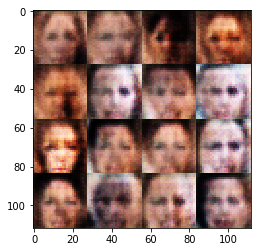

Epoch 1/1... Steps 1110   Discriminator Loss: 1.0961... Generator Loss: 1.2330
Epoch 1/1... Steps 1120   Discriminator Loss: 0.8169... Generator Loss: 1.9505
Epoch 1/1... Steps 1130   Discriminator Loss: 0.9854... Generator Loss: 1.1909
Epoch 1/1... Steps 1140   Discriminator Loss: 1.0055... Generator Loss: 1.7680
Epoch 1/1... Steps 1150   Discriminator Loss: 0.8031... Generator Loss: 2.0841
Epoch 1/1... Steps 1160   Discriminator Loss: 1.1100... Generator Loss: 0.8066
Epoch 1/1... Steps 1170   Discriminator Loss: 0.8644... Generator Loss: 1.4069
Epoch 1/1... Steps 1180   Discriminator Loss: 0.8933... Generator Loss: 1.2878
Epoch 1/1... Steps 1190   Discriminator Loss: 1.5539... Generator Loss: 0.4522
Epoch 1/1... Steps 1200   Discriminator Loss: 1.1168... Generator Loss: 0.7847


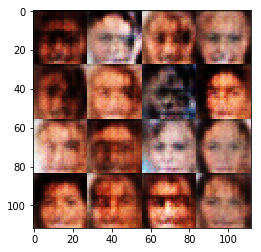

Epoch 1/1... Steps 1210   Discriminator Loss: 0.9881... Generator Loss: 1.0946
Epoch 1/1... Steps 1220   Discriminator Loss: 1.2076... Generator Loss: 1.1156
Epoch 1/1... Steps 1230   Discriminator Loss: 0.9989... Generator Loss: 1.1517
Epoch 1/1... Steps 1240   Discriminator Loss: 0.9286... Generator Loss: 2.2628
Epoch 1/1... Steps 1250   Discriminator Loss: 1.0992... Generator Loss: 0.9492
Epoch 1/1... Steps 1260   Discriminator Loss: 1.4298... Generator Loss: 0.5475
Epoch 1/1... Steps 1270   Discriminator Loss: 0.9466... Generator Loss: 1.3511
Epoch 1/1... Steps 1280   Discriminator Loss: 0.9214... Generator Loss: 1.0950
Epoch 1/1... Steps 1290   Discriminator Loss: 0.8870... Generator Loss: 1.2897
Epoch 1/1... Steps 1300   Discriminator Loss: 2.2577... Generator Loss: 4.5160


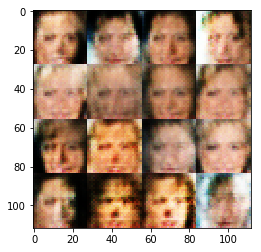

Epoch 1/1... Steps 1310   Discriminator Loss: 0.8894... Generator Loss: 2.4302
Epoch 1/1... Steps 1320   Discriminator Loss: 1.3592... Generator Loss: 3.2552
Epoch 1/1... Steps 1330   Discriminator Loss: 1.1894... Generator Loss: 0.9194
Epoch 1/1... Steps 1340   Discriminator Loss: 1.0513... Generator Loss: 0.7992
Epoch 1/1... Steps 1350   Discriminator Loss: 0.9324... Generator Loss: 1.3786
Epoch 1/1... Steps 1360   Discriminator Loss: 1.1149... Generator Loss: 0.8452
Epoch 1/1... Steps 1370   Discriminator Loss: 0.8918... Generator Loss: 1.5172
Epoch 1/1... Steps 1380   Discriminator Loss: 0.9301... Generator Loss: 1.1169
Epoch 1/1... Steps 1390   Discriminator Loss: 1.0614... Generator Loss: 0.9415
Epoch 1/1... Steps 1400   Discriminator Loss: 1.2981... Generator Loss: 0.6376


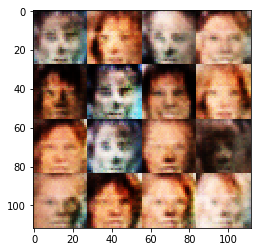

Epoch 1/1... Steps 1410   Discriminator Loss: 1.1538... Generator Loss: 0.7991
Epoch 1/1... Steps 1420   Discriminator Loss: 0.7008... Generator Loss: 1.6357
Epoch 1/1... Steps 1430   Discriminator Loss: 0.7219... Generator Loss: 1.9305
Epoch 1/1... Steps 1440   Discriminator Loss: 1.0369... Generator Loss: 0.9430
Epoch 1/1... Steps 1450   Discriminator Loss: 1.4678... Generator Loss: 0.4915
Epoch 1/1... Steps 1460   Discriminator Loss: 1.0756... Generator Loss: 0.8632
Epoch 1/1... Steps 1470   Discriminator Loss: 0.8814... Generator Loss: 2.5395
Epoch 1/1... Steps 1480   Discriminator Loss: 1.0250... Generator Loss: 2.4697
Epoch 1/1... Steps 1490   Discriminator Loss: 0.6593... Generator Loss: 1.8349
Epoch 1/1... Steps 1500   Discriminator Loss: 0.7778... Generator Loss: 1.6266


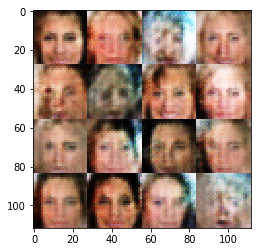

Epoch 1/1... Steps 1510   Discriminator Loss: 0.8247... Generator Loss: 1.2172
Epoch 1/1... Steps 1520   Discriminator Loss: 0.9243... Generator Loss: 1.0239
Epoch 1/1... Steps 1530   Discriminator Loss: 1.1467... Generator Loss: 0.8237
Epoch 1/1... Steps 1540   Discriminator Loss: 0.8815... Generator Loss: 1.9969
Epoch 1/1... Steps 1550   Discriminator Loss: 1.1073... Generator Loss: 0.7640
Epoch 1/1... Steps 1560   Discriminator Loss: 0.8393... Generator Loss: 2.9132
Epoch 1/1... Steps 1570   Discriminator Loss: 0.8562... Generator Loss: 1.7669
Epoch 1/1... Steps 1580   Discriminator Loss: 0.8503... Generator Loss: 1.5639
Save checkpoint
End Training


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

print_every = 10
show_every  = 100
n_images = 16

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。